In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


date : Fri Oct  4 23:57:22 UTC 2019
hostname : sedna
nvidia-smi -L : GPU 0: GeForce GTX 1080 Ti (UUID: GPU-2d5cf167-db75-89ec-c6f7-5639237768ce)
pwd : /home/tmb/exp/icdar2019-worksheets


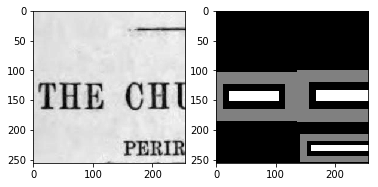

In [2]:
from importlib import reload

import os
import sys
import re
import glob
import time
import pickle
import scipy.ndimage as ndi
from itertools import islice
import IPython
import logging
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchmore import layers, flex
import torchtrainers as tt
from torch.utils.data import DataLoader
from webdataset import WebDataset
from ocrlib import ocrhelpers as helpers
from ocrlib import ocrmodels as models
from ocrlib.ocrhelpers import method, asnp
import matplotlib.pyplot as plt

plt.rc("image", cmap="gray")
plt.rc("image", interpolation="nearest")

transforms = [
    lambda x: (torch.tensor(x).float()/255.0).unsqueeze(0),
    lambda y: torch.tensor(y).long()
]
training = WebDataset("data/seg-{000000..000019}.tar", decoder="l8", 
                      extensions="image.png target.png", transforms=transforms)
training_dl = DataLoader(training, batch_size=5)

def RUN(x): print(x, ":", os.popen(x).read().strip())
    
RUN("date"); RUN("hostname"); RUN("nvidia-smi -L"); RUN("pwd")
images, targets, = next(iter(training_dl))
subplot(121); imshow(images[0,0]); subplot(122); imshow(targets[0])

In [3]:
model = models.make("seg_conv")
model

Sequential(
  (0): Input(BDHW->BDHW torch.float32 (0, 1) cuda:0 [None, 1, None, None])
  (1): KeepSize(
    (sub): Sequential(
      (0): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU()
      (13): Conv2d(100, 100, kernel_siz

In [4]:
!mkdir -p models

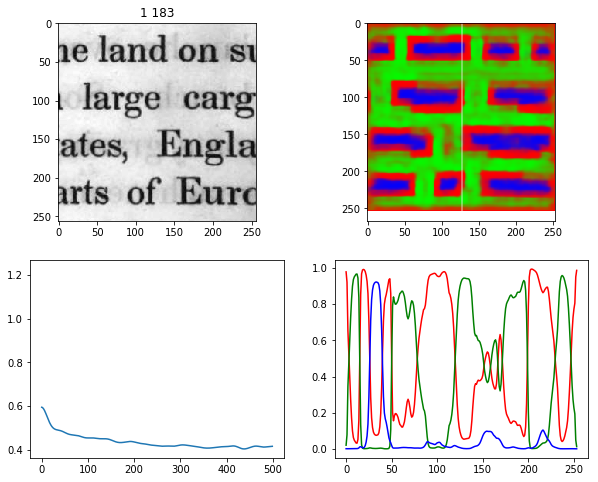

In [5]:
trainer = helpers.SegTrainer(model)
trainer.train(training_dl, learning_rates=[1e-3]+[1e-4]*3, every=15)